In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile

In [2]:
random.seed(1337)
np.random.seed(1337)
tf.random.set_seed(1337)

In [3]:
with ZipFile("archive.zip","r") as zip:
	zip.extractall()

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	"train",
	shuffle = True,
	image_size = IMG_SIZE,
	batch_size = BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	"val",
	shuffle = True,
	image_size = IMG_SIZE,
	batch_size = BATCH_SIZE,
)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

Found 357507 files belonging to 2 classes.
Found 71504 files belonging to 2 classes.


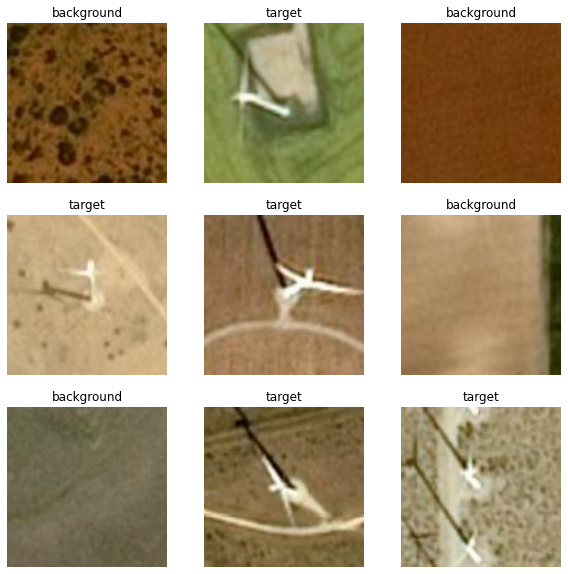

In [6]:
class_names = train_ds.class_names

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
	for i in range(9):
		ax = plt.subplot(3,3,i+1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")

### Data augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
	tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
])

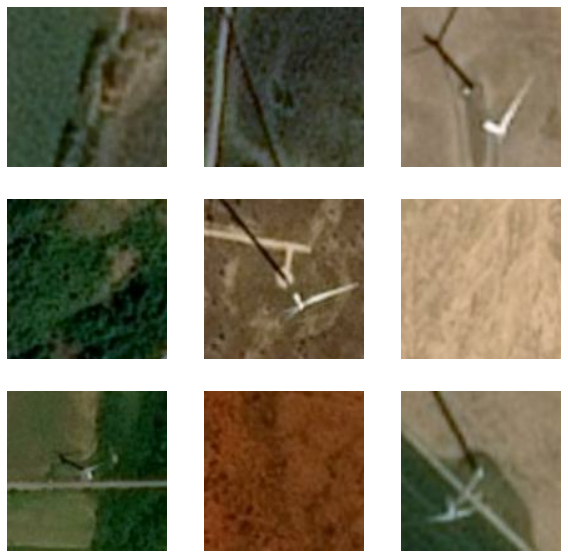

In [8]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Define the model

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = (160,160,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")
image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)

def get_model():
	inputs = tf.keras.Input(shape=(160,160,3))
	x = data_augmentation(inputs)
	x = preprocess_input(x)
	x = base_model(x,training=False)
	x = global_average_layer(x)
	x = tf.keras.layers.Dropout(0.2,seed=1337)(x)
	outputs = prediction_layer(x)
	model = tf.keras.Model(inputs,outputs)
	return model

model = get_model()
model.summary()
model.compile(tf.keras.optimizers.Adam(),tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

### Train and test the model on test dataset

In [11]:
if __name__=="__main__":
	initial_epochs = 1
	loss0,accuracy0 = model.evaluate(val_ds)
	print("Initial loss: {:.2f} %".format(100*loss0))
	print("Initial accuracy: {:.2f} %".format(100*accuracy0))
	checkpoint = tf.keras.callbacks.ModelCheckpoint("airbus.h5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
	model.fit(train_ds,epochs=initial_epochs,validation_data=val_ds,callbacks=[checkpoint])
	best = tf.keras.models.load_model("airbus.h5")
	loss,accuracy = best.evaluate(test_ds)
	print("\nTest accuracy: {:.2f} %".format(100*accuracy))
	print("Test loss: {:.2f} %".format(100*loss))

1788/1788 [==============================] - 75s 40ms/step - loss: 1.0186 - accuracy: 0.3431
Initial loss: 101.86 %
Initial accuracy: 34.31 %
11173/11173 [==============================] - 513s 46ms/step - loss: 0.0602 - accuracy: 0.9783 - val_loss: 0.0456 - val_accuracy: 0.9837


/home/maverick/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


447/447 [==============================] - 18s 39ms/step - loss: 0.0479 - accuracy: 0.9825

Test accuracy: 98.25 %
Test loss: 4.79 %
